<a href="https://colab.research.google.com/github/christianhidber/easyagents/blob/master/jupyter_notebooks/workshop/orso.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Orso's live

Make our bear Orso find all the honey in his home turf choosing the most convenient path.  

<img src='https://github.com/christianhidber/easyagents/blob/master/jupyter_notebooks/workshop/orso.png?raw=1'>


<img src='https://github.com/christianhidber/easyagents/blob/master/jupyter_notebooks/workshop/turf.png?raw=1'>


https://opendatascience.com/bears-need-to-learn-as-well-practical-reinforcement-learning-with-tensorflow-2-0-tf-agents

### Install gym, tensorflow, tf-agents,..., setup display

In [1]:
import sys
if 'google.colab' in sys.modules:
    !pip install -q easyagents
    
!pip install -q networkx==2.3.0 

In [2]:
import easyagents
easyagents.__version__

c:\users\olive\anaconda3\envs\easyagents\lib\site-packages\gym\logger.py:30: UserWarning: WARN: gym.spaces.Box autodetected dtype as <class 'numpy.float32'>. Please provide explicit dtype.
  warnings.warn(colorize('%s: %s'%('WARN', msg % args), 'yellow'))



  TensorFlow's `tf-nightly` package will soon be updated to TensorFlow 2.0.

  Please upgrade your code to TensorFlow 2.0:
    * https://www.tensorflow.org/beta/guide/migration_guide

  Or install the latest stable TensorFlow 1.X release:
    * `pip install -U "tensorflow==1.*"`

  Otherwise your code may be broken by the change.

  




Using TensorFlow backend.


'1.1.22'

##### suppress package warnings, in colab: load additional packages for rendering

In [3]:
import sys
import warnings
import matplotlib.pyplot as plt

warnings.filterwarnings('ignore')
if 'google.colab' in sys.modules:
    !apt-get install xvfb >/dev/null
    !pip install pyvirtualdisplay >/dev/null    
    
    from pyvirtualdisplay import Display
    Display(visible=0, size=(960, 720)).start() 

# Define Gym Environment

<img src='https://github.com/christianhidber/easyagents/blob/master/jupyter_notebooks/workshop/gym.png?raw=1'>

http://gym.openai.com/

## Our focus is a bit different

* the gym has originally been designed by reinforcement learning researchers as a suite of environments to comapre difference algorithms
* it has a nice API supported by all major reinforcement learning libraries
* since we are practitioners we use that same API to build our own environments

## How does the API look like?
* an environment is a Python class
* `step` as its main method
* it takes the action and returns the new observation, the reward, and if the game is done
* the environment also makes you defined how an observation looks like and what actions can be performed
* this is important to configure the agent
* in our case the agents strategy is always defined as a TensorFlow neural network
* it is configured to take the observationa as input and outputs a probability for each action
* this probability describes the chance of this action to be the most successful
* you would also defined an `__init__` (constructor), a `reset` method, and a `render` method

## Skeleton of an Environment
```python
class MyEnv(gym.Env):
  def __init__(self):
      # set up the environment

    def step(self, action):
        # make the action have an impact on the environment
        # and return the information the algorithms need
        return observation, reward, done, info

    def reset(self):
        # reset this environment to the initial state and return the according observation
        return observation

    def render(self, mode='ansi'):
        # spits out a human readable rendering of the environment
        if mode == 'ansi':
            return self._render_ansi()
        elif mode == 'rgb_array':
            return self._render_rgb()
        else:
            super().render(mode=mode)
  
```

## Structure of Observation and Reward are crucial
* agents can learn short cuts and unexpected behavior
* Funny list of machines learned as opposed what the designers intended them to learn
  * `Reward-shaping a soccer robot for touching the ball caused it to learn to get to the ball and vibrate touching it as fast as possible`
  * `Robot hand pretending to grasp an object by moving between the camera and the object`
  * `Simulated pancake making robot learned to throw the pancake as high in the air as possible in order to maximize time away from the ground`
  * `Agent pauses the game indefinitely to avoid losing`
  * `In an artificial life simulation where survival required energy but giving birth had no energy cost, one species evolved a sedentary lifestyle that consisted mostly of mating in order to produce new children which could be eaten (or used as mates to produce more edible children).`
  * `Agent kills itself at the end of level 1 to avoid losing in level 2`
  * `Evolved player makes invalid moves far away in the board, causing opponent players to run out of memory and crash`
  * `Creatures exploited physics simulation bugs by twitching, which accumulated simulator errors and allowed them to travel at unrealistic speeds`
  * `Reward-shaping a bicycle agent for not falling over & making progress towards a goal point (but not punishing for moving away) leads it to learn to circle around the goal in a physically stable loop.`
  * `... algorithm learns to bait an opponent into following it off a cliff, which gives it enough points for an extra life, which it does forever in an infinite loop.`
  * `The PPO algorithm discovers that it can slip through the walls of a level to move right and attain a higher score.`

Source: https://vkrakovna.wordpress.com/2018/04/02/specification-gaming-examples-in-ai/
  * https://arxiv.org/abs/1803.03453 
  * https://docs.google.com/spreadsheets/u/1/d/e/2PACX-1vRPiprOaC3HsCf5Tuum8bRfzYUiKLRqJmbOoC-32JorNdfyTiRRsR7Ea5eWtvsWzuxo8bjOxCG84dAg/pubhtml
  * https://twitter.com/mogwai_poet/status/1060286856493813760



### Imports

In [4]:
import gym
from gym.utils import seeding
from gym import spaces
import matplotlib.image as mpi
from matplotlib.offsetbox import (OffsetImage, AnnotationBbox)
from IPython.display import display, clear_output
import networkx as nx
import numpy as np
import random

### Helper methods

In [5]:
def state_name_to_int(state):
    state_name_map = {
        'S': 0,
        'A': 1,
        'B': 2,
        'C': 3,
        'D': 4,
        'E': 5,
        'F': 6,
        'G': 7,
        'H': 8,
        'K': 9,
        'L': 10,
        'M': 11,
        'N': 12,
        'O': 13,
        'P': 14,
        'Q': 15,
        'R': 16,
        'T': 17,
        'U': 18,
        'V': 19,
        'W': 20,
        'X': 21,
        'Y': 22,
        'Z': 23
    }
    return state_name_map[state]

def int_to_state_name(state_as_int):
    state_map = {
        0: 'S',
        1: 'A',
        2: 'B',
        3: 'C',
        4: 'D',
        5: 'E',
        6: 'F',
        7: 'G',
        8: 'H',
        9: 'K',
        10: 'L',
        11: 'M',
        12: 'N',
        13: 'O',
        14: 'P',
        15: 'Q',
        16: 'R',
        17: 'T',
        18: 'U',
        19: 'V',
        20: 'W',
        21: 'X',
        22: 'Y',
        23: 'Z'
    }
    return state_map[state_as_int]

# This will be the cell where you redefine Orso's world (not now, later!)

* Each row defines one location in Orso's world
* S stands for start and is the cave Orso lives in
* Each location has access to up to 4 other locations defined in each row
* Each connection is attributed with a value which is the cost of traveling the connection
* You can change this graph in the first hands-on of this notebook described later in this notebook 
* Anything preceded by the \# is a comment

In [6]:
# this is a comment

graph = {
            'S': [('A', 300), ('B', 100), ('C', 200)],
            'A': [('S', 300), ('B', 100), ('E', 100), ('D', 100)],
            'B': [('S', 100), ('A', 100), ('C', 50), ('K', 200)],
            'C': [('S', 200), ('B', 50), ('M', 100), ('L', 200)],
            'D': [('A', 100), ('F', 50)],
            'E': [('A', 100), ('F', 100), ('H', 100)],
            'F': [('D', 50), ('E', 100), ('G', 200)],
            'G': [('F', 200), ('O', 300)],
            'H': [('E', 100), ('K', 300)],
            'K': [('B', 200), ('H', 300)],
            'L': [('C', 200), ('M', 50)],
            'M': [('C', 100), ('L', 50), ('N', 100)],
            'N': [('M', 100), ('O', 100)],
            'O': [('N', 100), ('G', 300)]
# this is how you could add a new node (make sure to remove N and O node above)
            # 'N': [('M', 100), ('O', 100), ('Z', 100)],
            # 'O': [('N', 100), ('G', 300), ('Z', 300)],
            # 'Z': [('O', 300), ('N', 100)]
        }

### Orso's Environment (OpenAI Gym)

In [7]:
class OrsoEnv(gym.Env):
    metadata = {'render.modes': ['ansi']}
    showStep = False

    def __init__(self):
        self.map = graph
        max_paths = 4
        self.action_space = spaces.Discrete(max_paths)

        positions = len(self.map)
        # observations: position, reward of all 4 local paths, rest reward of all locations
        # non existing path is -1000 and no position change
        # look at what #getObservation returns if you are confused
        low = np.append(np.append([0], np.full(max_paths, -1000)), np.full(positions, 0))
        high = np.append(np.append([positions - 1], np.full(max_paths, 1000)), np.full(positions, 1000))
        self.observation_space = spaces.Box(low=low,
                                            high=high,
                                            dtype=np.float32)
        self.reward_range = (-1, 1)
        self.envEpisodeCount = 0
        self.envStepCount = 0
        self._figure = None

        self.reset()
        self.optimum = self.calculate_customers_reward()

        base = "https://raw.githubusercontent.com/christianhidber/easyagents/master/images/"
        self.image_orso = mpi.imread(base + "Bear.png")
        self.image_cave = mpi.imread(base + "Cave.png")
        self.image_honey = mpi.imread(base + "Honey.png")
        self.image_empty_pot = mpi.imread(base + "EmptyPot.png")
        self.nx_graph, self.nx_pos = self._create_nx_graph()

    def seed(self, seed=None):
        self.np_random, seed = seeding.np_random(seed)
        return [seed]

    def iterate_path(self, state, action):
        paths = self.map[state]
        if action < len(paths):
            return paths[action]
        else:
            # sorry, no such action, stay where you are and pay a high penalty
            return (state, 1000)

    def step(self, action):
        destination, cost = self.iterate_path(self.state, action)

        self.cost = cost
        self.action = action
        self.lastStep_state = self.state
        self.state = destination
        self.customerReward = self.customer_reward[destination]
        self.reward = 0
        self.reward = (self.customerReward - self.cost) / self.optimum

        self.customer_visited(destination)
        done = (destination == 'S' and self.all_customers_visited())

        stateAsInt = state_name_to_int(self.state)
        self.totalReward += self.reward
        self.stepCount += 1
        self.envStepCount += 1

        if done and not self.isDone:
            self.envEpisodeCount += 1

        self.isDone = done
        observation = self.getObservation(stateAsInt)
        info = {"from": self.state, "to": destination}
        return observation, self.reward, done, info

    def getObservation(self, position):
        result = np.array([position,
                           self.getPathObservation(position, 0),
                           self.getPathObservation(position, 1),
                           self.getPathObservation(position, 2),
                           self.getPathObservation(position, 3)
                           ],
                          dtype=np.float32)
        all_rest_rewards = list(self.customer_reward.values())
        result = np.append(result, all_rest_rewards)
        return result

    def getPathObservation(self, position, path):
        paths = self.map[self.state]
        if path < len(paths):
            target, cost = paths[path]
            reward = self.customer_reward[target]
            result = reward - cost
        else:
            result = -1000

        return result

    def customer_visited(self, customer):
        self.customer_reward[customer] = 0

    def all_customers_visited(self):
        return self.calculate_customers_reward() == 0

    def calculate_customers_reward(self):
        sum = 0
        for value in self.customer_reward.values():
            sum += value
        return sum

    # each node gets a reward, either 0 or 10000
    def modulate_reward(self):
        self.customer_reward = {}

        node_names = list(self.map.keys())
        # initialize all nodes with 0
        for node_name in node_names:
            self.customer_reward[node_name] = 0

        # 10000 rewards are only at a few random places
        number_of_customers = len(self.map) - 1
        number_per_consultant = int(number_of_customers / 2)
        self._honeypot_places = []

        # starting from 1, not 0, so that 'S' (position of the cave) never gets a reward 
        samples = random.sample(range(1, number_of_customers + 1), k=number_per_consultant)
        for sample in samples:
            self.customer_reward[node_names[sample]] = 1000
            self._honeypot_places = self._honeypot_places + [node_names[sample]]

    def reset(self):
        self.totalReward = 0
        self.stepCount = 0
        self.isDone = False
        self.state = 'S'
        self.cost = 0
        self.action = 0
        self.lastStep_state = ''
        self.customerReward = None
        self._honeypot_places = None
        self.reward = 0
        self.envEpisodeCount += 1
        self.modulate_reward()
        self._figure = None
        return self.getObservation(state_name_to_int(self.state))

    def _create_nx_graph(self):
        """ generates the networkx graph representing orso's world with all its paths.

        :return: graph, positions
        """
        nx_graph = nx.Graph()
        for node_id in self.map.keys():
            zoom = 0.6
            image = self.image_empty_pot
            nx_graph.add_node(node_id, image=image, zoom=zoom)
        for source, connections in self.map.items():
            for target, cost in connections:
                if cost >= 300:
                    color = 'dodgerblue'
                elif cost >= 200:
                    color = 'darkgoldenrod'
                elif cost >= 100:
                    color = 'forestgreen'
                else:
                    color = 'greenyellow'
                nx_graph.add_edge(source, target, color=color, weight=6, image=self.image_cave)
        nx_pos = nx.kamada_kawai_layout(nx_graph)
        return nx_graph, nx_pos

    def _render_to_figure(self):
        """ Renders the current state as a graph with matplotlib
        """
        # draw graph using matplotlib
        if (self._figure is not None):
            plt.close(self._figure)
        self._figure = plt.figure("BeraterEnv", figsize=(12, 9))
        if len(self._figure.axes) == 0:
            self._figure.add_subplot(1, 1, 1)
        self._figure.axes[0].cla()
        ax = self._figure.axes[0]

        edges = self.nx_graph.edges()
        edge_colors = [self.nx_graph[u][v]['color'] for u, v in edges]
        edge_weights = [self.nx_graph[u][v]['weight'] for u, v in edges]
        nx.draw(self.nx_graph, pos=self.nx_pos, ax=ax, node_color='lightgrey',
                edges=edges, edge_color=edge_colors, width=edge_weights, with_labels=True)

        # draw images on graph nodes
        # set image (according to the current state) and sizes (make orso's current position larger)
        for node_id in self.nx_graph.nodes():
            node = self.nx_graph.node[node_id]
            node['zoom'] = 0.4
            if node_id == self.state:
                node['zoom'] = 0.6
            if node_id in self._honeypot_places:
                node['image'] = self.image_empty_pot
                if self.customer_reward[node_id] > 0:
                    node['image'] = self.image_honey
            else:
                node['image'] = None
            if node_id == 'S':
                node['image'] = self.image_cave
            if self.state == node_id:
                node['image'] = self.image_orso

        # position images
        for n in self.nx_pos:
            node = self.nx_graph.node[n]
            image = node['image']
            if image is not None: 
                xp, yp = self.nx_pos[n]
                offset_image = OffsetImage(image, node['zoom'])
                offset_image.image.axes = ax
                ab = AnnotationBbox(offset_image, (xp, yp),
                                    xybox=(0, 0),
                                    xycoords='data',
                                    boxcoords="offset points",
                                    pad=0.0,
                                    frameon=False
                                    )
                ax.add_artist(ab)

        self._figure.canvas.draw()

    def _render_ansi(self):
        result = ("Episode: " + ("%4.0f  " % self.envEpisodeCount) +
                  " Step: " + ("%4.0f  " % self.stepCount) +
                  self.lastStep_state + ' --' + str(self.action) + '-> ' + self.state +
                  ' R=' + ("% 2.2f" % self.reward) + ' totalR=' + ("% 3.2f" % self.totalReward) +
                  ' cost=' + ("%4.0f" % self.cost) + ' customerR=' + ("%4.0f" % self.customerReward) + ' optimum=' + (
                          "%4.0f" % self.optimum)
                  )
        return result

    def _render_rgb(self):
        self._render_to_figure()
        self._figure.canvas.draw()
        buf = self._figure.canvas.tostring_rgb()
        num_cols, num_rows = self._figure.canvas.get_width_height()
        plt.close(self._figure)
        self._figure = None
        result = np.fromstring(buf, dtype=np.uint8).reshape(num_rows, num_cols, 3)
        return result

    def render(self, mode='human'):
        if mode == 'ansi':
            return self._render_ansi()
        elif mode == 'human':
            clear_output(wait=True)
            self._render_to_figure()
            plt.pause(0.01)
            return
        elif mode == 'rgb_array':
            return self._render_rgb()
        else:
            super().render(mode=mode)
          

# First Steps

Orso - the bear - lives in his cave (position 'S'). Orso knows his area and where he can 
typically find some honey (positions 'A' to 'O'). The honey places are scattered all over his home turf and connected
by some pathways. Some connections are easy like walking over a grassy field (light green, very low cost) or forests 
(dark green, low cost), a bit strenuous like walking over a hill (brown, higher costs) and very arduous like swimming 
through a lake (blue, very high costs).

There are other bears around competing for the honey pots. So some spots have honey (yellow nodes) and some
are already taken (brown nodes).

Every morning, Orso awakes and starts looking for some honey. But every day, the honey pots are at a new place
( env.reset() ). So Orso climbs a tree near his cave to find out where the honey is. Even with this knowledge it is not clear which route he should take. Being a bear also means being lazy, so Orso wants to get as much honey as possible while at the lowest costs possible. At each spot he has to decide where to go next (the action). His daily journey ends when his back in his own cave.

Be god and create Orso's world:

In [8]:
env = OrsoEnv()

A new morning starts (rerun the cell below to see how the honey pots change places). But Orso 
(depicted in 'fuchsia', Marsha's favorite color ?) doesn't know 
about the sweetness of honey or his surroundings. So the climbs a tree to get an overview and this is what he sees:

In [9]:
# this is the observation the agent will see
env.reset()

array([    0.,  -300.,   900.,   800., -1000.,     0.,     0.,  1000.,
        1000.,     0.,     0.,     0.,  1000.,     0.,     0.,  1000.,
           0.,  1000.,  1000.])

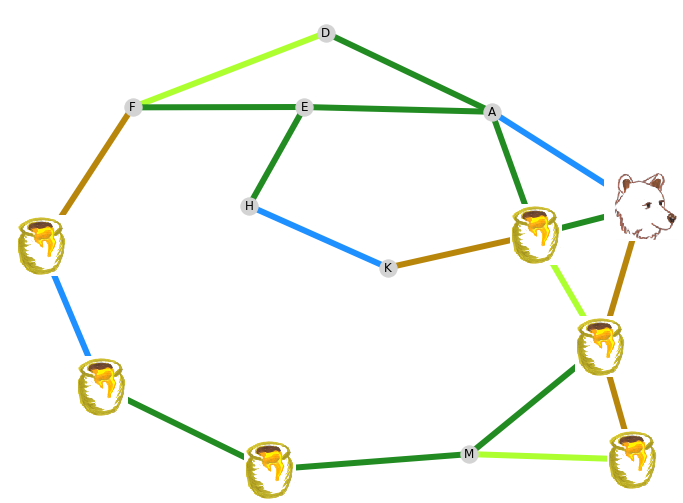

In [10]:
env.render()

Take Orso by his paws and go for a few steps:

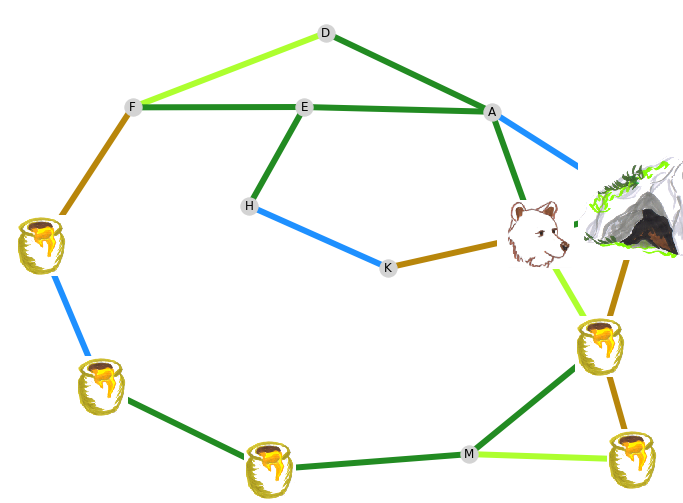

Episode:    2   Step:    1  S --1-> B R= 0.15 totalR= 0.15 cost= 100 customerR=1000 optimum=6000


In [11]:
env.step(1)
env.render()
print(env.render(mode='ansi'))

Note that the honey pot nodes turn brown once Orso has passed and taken the honey.

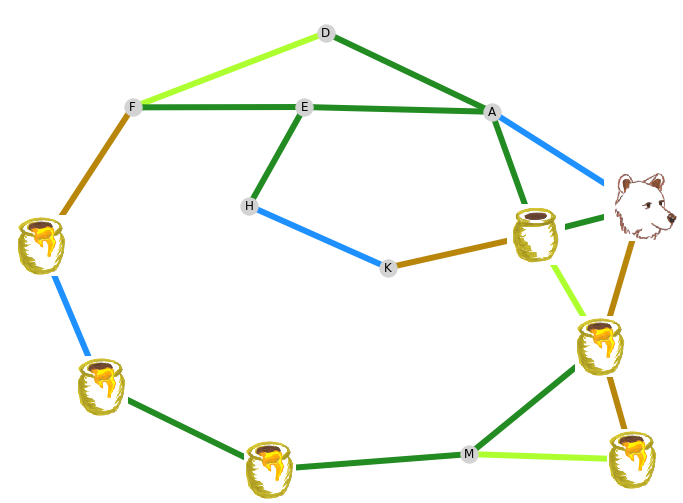

Episode:    2   Step:    2  B --0-> S R=-0.02 totalR= 0.13 cost= 100 customerR=   0 optimum=6000


In [12]:
env.step(0)
env.render()
print(env.render(mode='ansi'))

Now Orso must start to learn by himself to take actions to gather all the honey while minimizing the effort:

### Let's see how a random policy moves our dear Orso

In [14]:
%%time

from easyagents.env import register_with_gym
from easyagents.agents import RandomAgent
from easyagents.callbacks import plot

env_name="Orso-v1"
register_with_gym(gym_env_name=env_name, entry_point=OrsoEnv, max_episode_steps=1000)

rndAgent = RandomAgent(gym_env_name='Orso-v1')
rndAgent.play([plot.State(),plot.Actions(), plot.StepRewards()], num_episodes=3, max_steps_per_episode=30)

Wall time: 417 ms


### Let's see how our average score is doing

In [18]:
mean, std, min, max, all = rndAgent.score()
mean

-2.6894999999999993

# Hands-On 1: Define Orso's world and make him move in it
* run the notebook up to this point
* define your version of Orso's world by changing the graph in the cell marked above
* consider
  * adding and connecting new nodes
  * removing nodes and their connections
  * adding connections between existing nodes
* You can use letters A-Z as names for nodes, except for I and J
* If you refer to a node, you need to define its outgoing connections as well
* Typically connections are simmetrical, that means you specify them both ways
* look at Orso move in this new world

# STOP HERE

# Train policy with tfagents PpoAgent


Wall time: 1min 14s


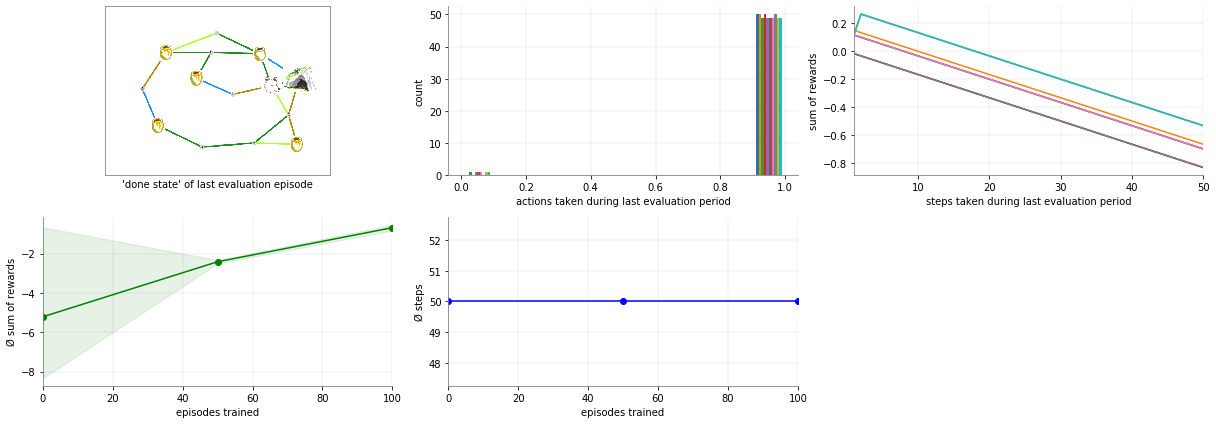

In [19]:
%%time

from easyagents.agents import PpoAgent

register_with_gym(gym_env_name=env_name, entry_point=OrsoEnv, max_episode_steps=1000)
ppoAgent = PpoAgent(gym_env_name=env_name, fc_layers=(500,500,500))

plots = [plot.State(), plot.Actions(), plot.StepRewards(), plot.Rewards(), plot.Steps(), plot.ToMovie()]
ppoAgent.train(plots, 
               learning_rate=1e-4, # ignore this one
               num_iterations = 500, 
               num_episodes_per_iteration = 10,
               max_steps_per_episode = 50)

In [20]:
mean, std, min, max, all = ppoAgent.score()
mean

-0.6646666666666671

# Hands-On 2: Run the cells above and watch the agent (Orso) learn

* run the notebook up to this point
* full training of the agent can take up to 25 minutes
  * so you are advised to reduce the number of iterations to 100 or even 50 (from 500)
  * note that depending on how your world looks like and for how long you train, you might not get good results
* while the training is running watch how the graphs evolve and make sense out of it
* answer the questions below

Questions:
* Why is the bear sometimes not ending up in its cave?
* Why is the position of the honey pots constantly changing in the state plot (the one on the right)?
* Is there any relation between the sum of rewards and number of steps?
* Can you make sense of all the other plots?
* Why do you get a negative reward at the beginning?
* How good do you think the reward can get?
* What is a good number of steps?


# STOP HERE

## Our Observations

* Note from the histogram that Orso initially is stuck with action 0. As the training proceeds the other actions are also discovered, resulting on average in shorter episodes and more rewards. 
* Also the state plot (rendering the state of the last evaluation episodes last step) shows that Orso starts to find more honey pots on its way back home. 
* Note that action 3 is less likely than the other actions. That's because we only have a few positions with 3 or more valid directions but all positions have at least 2 directions.

## Play - see the bear cruise his turf (turn ouput into a movie)

In [ ]:
ppoAgent.play([plot.State(), plot.StepRewards(num_steps_between_plot=1), plot.Actions(), plot.ToMovie(fps=3)], 
              num_episodes=5, max_steps_per_episode=20)

Play uses the previously trained policy. We play for 5 episodes, each with max 20 steps. All steps are rendered into a movie with a frame rate of 3 steps per second.

# How good can you get? What is the optimum?

* generally you just do not know
* the higher the score the better
* baselines can help in Reinforcement Learning as well
* in our special case, there is a deterministic baseline
  * best first search (https://en.wikipedia.org/wiki/Dijkstra%27s_algorithm)
  * guarentees to find optimal solution
  * exponential complexity
  * but works fine for our size of the problem
  * optimal score between _.73_ and _.74_ with very low variance
  * number of steps to pass through complete turf around _17_
* our reinforcement learning approach trades the perfect solution for
  * nearly perfect solution 
  * linear time complexity
